In [1]:
import sklearn.tree
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics
from timeit import default_timer as timer

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/home/benjamin/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/benjamin/venv/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [52]:
features_pd = pd.read_csv('ring_features_p.csv.bz2', compression='bz2')
prices_pd = pd.read_csv('ring_prices.csv')
prices_pd.rename(columns={'valuable':'price'}, inplace=True)
targets_pd = prices_pd['price'].apply(lambda x: 1 if x > 0 else 0)
full_pd = features_pd.copy()
full_pd['valuable'] = targets_pd
full_pd['price'] = prices_pd['price']

features = features_pd.as_matrix()[:,1:]
targets = targets_pd.as_matrix()
prices = prices_pd['price'].apply(lambda x: min(x, 100)).as_matrix()
error_cost = (1-targets) + 2*prices
#error_cost /= error_cost.max()
print(features.shape, targets.shape)

print("Max Price:", prices.max())
print("Average Price:", prices.mean())

(225191, 38) (225191,)
Max Price: 100.0
Average Price: 3.5203434862


In [40]:
tmask = np.random.choice([False,True], len(targets), p=[0.25, 0.75])
vmask = np.invert(tmask)
train_X = features[tmask]
train_Y = targets[tmask]
test_X = features[vmask]
test_Y = targets[vmask]

print("Training set: {} items, {:.1f}% valuable".format(train_X.shape[0], 100*(sum(train_Y) / train_Y.shape[0])))
print("Validation set: {} items, {:.1f}% valuable".format(test_X.shape[0], 100*(sum(test_Y) / test_Y.shape[0])))

target = 'valuable'
predictors = [x for x in full_pd.columns if x not in [target, 'Unnamed: 0', 'price']]

def eval_error(preds, dtrain):
    """
    Error metric: Lost time for the player.
    False positives (worthless items kept) cost 10 seconds per item.
    False negatives (valuable items lost) cost 3 minutes per value in chaos.
    """
    labels = dtrain.labels()
    time_loss = (preds - labels) * g_error_cost
    return 'error', float(sum(time_loss)) / len(labels)
    
def objective_playtime(preds, _dtrain):
    """
    Objective function using same error metric as eval_error.
    We keep the gradients produced by xgBoost, but weight them by the time loss.
    """
    #labels = _dtrain.get_label()
    labels = _dtrain
    grad = (preds - labels) * g_error_cost #(preds - labels) / error_cost
    hess = np.ones(shape=preds.shape)/300 # preds * (1.0 - preds)
    return grad, hess


Training set: 168613 items, 41.1% valuable
Validation set: 56578 items, 41.4% valuable


In [ ]:
cv_params = {'colsample_bytree': [0.7,0.8,0.9]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth':9, 'min_child_weight':6, 'gamma':0.15,
              'seed':41083, 'subsample': 0.8, 'colsample_bytree':0.8, 'objective':'binary:logistic', 
              'scale_pos_weight':1}
scorer = metrics.make_scorer(objective_playtime, greater_is_better=False, needs_proba=True)
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), param_grid=cv_params, cv=5, n_jobs=4, iid=False, 
                             scoring=scorer)
start = timer()
optimized_GBM.fit(train_X, train_Y)
deltaTime = timer() - start
s = deltaTime % 60           
m = (deltaTime // 60) % 60  
h = deltaTime // 3600      
print("Training done after {}h {}m {}s".format(h,m,s))

In [ ]:
optimized_GBM.grid_scores_, optimized_GBM.best_params_, optimized_GBM.best_score_

(168613, 41) (168613,)

Model Report
Accuracy : 0.4758
AUC Score (Train): 0.755352


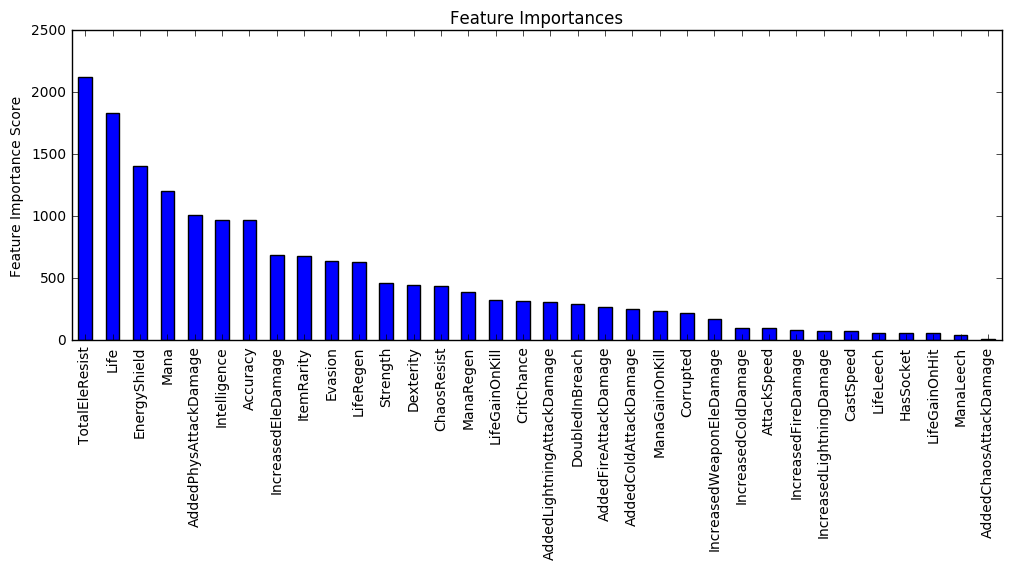

In [53]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], g_error_cost)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    #xgb.plot_tree()

ind_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth':9, 'min_child_weight':6, 'gamma':0.15,
              'seed':41083, 'subsample': 0.8, 'colsample_bytree':0.8, 'objective': 'binary:logistic', 
              'scale_pos_weight':1}

dtrain = full_pd[tmask]
g_prices = prices[tmask]
g_error_cost = error_cost[tmask]
print(dtrain.shape, g_prices.shape)
#params = {**ind_params, **optimized_GBM.best_params_, 'feval':eval_error}
params = {**ind_params}#, 'objective':objective_playtime}
model = xgb.XGBClassifier(**params)
modelfit(model, dtrain, predictors, useTrainCV=True)

Valuable Items Wasted: 805 (3.4%)
Worthless Items Kept: 29038 (87.6%)
Playtime Saved at 95% Junk: 7.0h 35.0m 17.056124626549718s
Playtime Wasted at 95% Junk: 19.0h 5.0m 53.13645326504775s
Manual Sort Time: 34.0h 41.0m 29.354758856177796s
Assisted Sort Time: 32.0h 30.0m 11.17614169868466s
Currency Wasted: 229.177121511 Chaos
Precision: [ 0.41411856  0.43793431  1.        ]
Recall: [ 1.          0.96564234  0.        ]


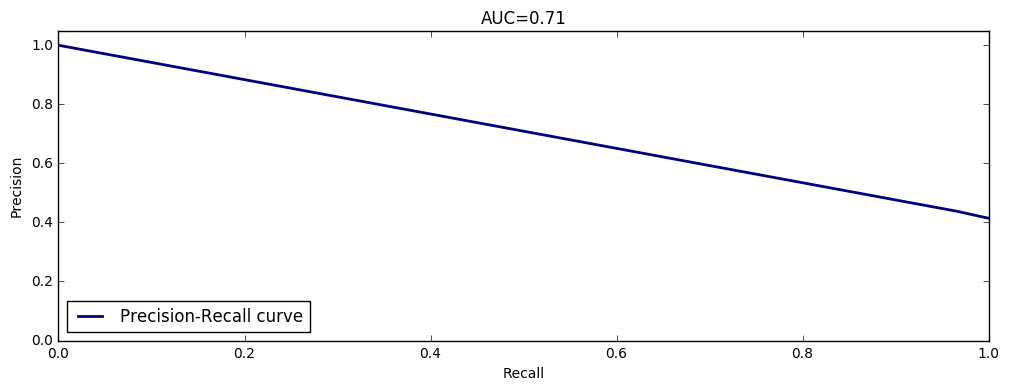

In [54]:
predictions = model.predict(full_pd[vmask][predictors])
ones = np.asarray([1]*predictions.shape[0])
precision, recall, _ = metrics.precision_recall_curve(test_Y, predictions)
average_precision = metrics.average_precision_score(test_Y, predictions)
#precision_micro, recall_micro, _ = metrics.precision_recall_curve(test_Y.ravel(), predictions.ravel())
#average_precision_micro = metrics.average_precision_score(test_Y.ravel(), predictions.ravel(), average='micro')

true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
invalid_stuff = 0
playtime_saved = 0
playtime_wasted = 0
for actual, predicted, p in zip(test_Y, predictions, prices[vmask]):
    if actual == 1 and predicted == 1:
        true_positives += 1
        playtime_saved += 10
    elif actual == 0 and predicted == 0:
        true_negatives += 1
        # This doesn't save time, player still has to price-check
    elif actual == 0 and predicted == 1:
        false_positives += 1
        # This doesn't waste time, player would do this without the tool anyway
    elif actual == 1 and predicted == 0:
        false_negatives += 1
        playtime_wasted += p * 300
    else:
        invalid_stuff += 1

valuable_percent = sum(test_Y) / len(test_Y)
playtime_saved = playtime_saved / valuable_percent * 0.05
playtime_wasted = playtime_wasted / valuable_percent * 0.05

manual_sort_time = (len(test_Y) - sum(test_Y)) * 10 + sum(test_Y) * 30
assisted_sort_time = false_positives * 10 + (sum(predictions) - false_positives) * 30
        
print("Valuable Items Wasted: {} ({:.1f}%)".format(false_negatives, 100*(false_negatives / (false_negatives + true_positives))))
print("Worthless Items Kept: {} ({:.1f}%)".format(false_positives, 100*(false_positives / (false_positives + true_negatives))))

def format_time(seconds):
    s = seconds%60
    m = (seconds//60)%60
    h = seconds//3600
    return "{}h {}m {}s".format(h,m,s)

print("Playtime Saved at 95% Junk:", format_time(playtime_saved))
print("Playtime Wasted at 95% Junk:", format_time(playtime_wasted))

print("Manual Sort Time:", format_time(manual_sort_time / valuable_percent * 0.05))
print("Assisted Sort Time:", format_time(assisted_sort_time / valuable_percent * 0.05))
print("Currency Wasted:", playtime_wasted / 300, "Chaos")

print("Precision:", precision)
print("Recall:", recall)

plt.clf()
plt.plot(recall, precision, lw=2, color='navy', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('AUC={:0.2f}'.format(average_precision))
plt.legend(loc='lower left')
plt.show()